# 5 XAI Analysis

## 5.1 Analysis of different model versions

In this section we aim to explore the effectiveness and impact of features on our different model versions to later keep the model that is best for our use case.

Imports

In [124]:
import shap
import os
import pickle
import pandas as pd
import json
import numpy as np

Read test data

In [125]:
data_path = os.path.join('..', 'output', 'test_data.pkl')

if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X_test, y_test = pickle.load(f)
        print(f"Test data loaded: {X_test.shape[0]} samples")
else:
    print(f"File not found: {data_path}")

Test data loaded: 2956 samples


Scale test data

In [126]:
# Load the scaler
with open('../output/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("Scaler loaded successfully")

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframe with same column names and index
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Test data scaled: {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features")

Scaler loaded successfully
Test data scaled: 2956 samples, 36 features


Open models and their metadata

In [127]:
def load_models():
    """
    Loads all models inside the ../models directory and their associated metadata.
    Stores them in a dictionary with model names as keys.
    """
    all_models = {}

    models_dir = os.path.join('..', 'models')

    if not os.path.exists(models_dir):
        print(f"Models directory not found: {models_dir}")
        return all_models

    for filename in os.listdir(models_dir):
        if filename.endswith('.pkl'):
            model_name_with_ext = filename
            model_base_name = filename.replace('.pkl', '')
            metadata_filename = f"{model_base_name}_metadata.json"

            model_path = os.path.join(models_dir, model_name_with_ext)
            metadata_path = os.path.join(models_dir, metadata_filename)

            loaded_model = None
            loaded_metadata = None

            # Load model
            try:
                with open(model_path, 'rb') as f:
                    loaded_model = pickle.load(f)
                print(f"Successfully loaded model: {model_name_with_ext}")
            except FileNotFoundError:
                print(f"Model file not found: {model_path}")
                continue
            except Exception as e:
                print(f"Error loading model {model_name_with_ext}: {e}")
                continue

            # Load metadata
            try:
                with open(metadata_path, 'r') as f:
                    loaded_metadata = json.load(f)
                print(f"Successfully loaded metadata: {metadata_filename}")
            except FileNotFoundError:
                print(f"Metadata file not found for {model_name_with_ext}: {metadata_path}")
            except Exception as e:
                print(f"Error loading metadata {metadata_filename}: {e}")

            if loaded_model is not None:
                all_models[model_base_name] = {
                    'model': loaded_model,
                    'metadata': loaded_metadata # Can be None if not found/loaded
                }

    return all_models

all_models = load_models()

print(f"Initialized all_models dictionary with {len(all_models)} models.")

Successfully loaded model: xgboost_nest123_depth1.pkl
Successfully loaded metadata: xgboost_nest123_depth1_metadata.json
Successfully loaded model: xgboost_nest40_depth7.pkl
Successfully loaded metadata: xgboost_nest40_depth7_metadata.json
Successfully loaded model: xgboost_nest48_depth5.pkl
Successfully loaded metadata: xgboost_nest48_depth5_metadata.json
Successfully loaded model: xgboost_nest91_depth4.pkl
Successfully loaded metadata: xgboost_nest91_depth4_metadata.json
Initialized all_models dictionary with 4 models.


SHAP analysis auxiliary function

SHAP analysis for each model

In [128]:
def shap_comparison(models_dict, X_data, top_n_features=5):
    """
    Performs SHAP analysis and returns two comparison tables: metrics and top features.
    """
    metrics_data = []
    features_data = []
    
    # Ensure X_data is numeric
    if isinstance(X_data, pd.DataFrame):
        X_data_numeric = X_data.astype(float)
    else:
        X_data_numeric = X_data

    for model_name, model_info in models_dict.items():
        model = model_info['model']
        metadata = model_info['metadata']
        
        # Get metrics
        metrics_entry = {'Model': model_name}
        if metadata and 'evaluation_metrics' in metadata and 'Test' in metadata['evaluation_metrics']:
            test_metrics = metadata['evaluation_metrics']['Test']
            metrics_entry['Accuracy'] = test_metrics.get('Accuracy', 0)
            metrics_entry['F1'] = test_metrics.get('F1', 0)
            metrics_entry['ROC-AUC'] = test_metrics.get('ROC-AUC', 0)
            metrics_entry['Precision'] = test_metrics.get('Precision', 0)
            metrics_entry['Recall'] = test_metrics.get('Recall', 0)
        metrics_data.append(metrics_entry)
        
        # Get top SHAP features
        features_entry = {'Model': model_name}
        try:
            # Use booster to avoid version compatibility issues
            booster = model.get_booster()
            explainer = shap.TreeExplainer(booster)
            shap_values = explainer(X_data_numeric)
            
            # Calculate mean absolute SHAP value for each feature
            mean_shap = np.abs(shap_values.values).mean(axis=0)
            feature_names = X_data.columns
            
            # Create a dataframe of feature importance
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': mean_shap
            }).sort_values('importance', ascending=False)
            
            # Get top N features
            top_features = importance_df.head(top_n_features)['feature'].tolist()
            
            # Add each feature as a separate column
            for i, feature in enumerate(top_features):
                features_entry[f'Rank {i+1}'] = feature
            
        except Exception as e:
            print(f"SHAP failed for {model_name}: {e}")
            features_entry['Rank 1'] = "Error"

        features_data.append(features_entry)

    # Create DataFrames
    metrics_df = pd.DataFrame(metrics_data)
    features_df = pd.DataFrame(features_data)
    
    # Reorder metrics columns
    metric_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
    existing_metric_cols = [c for c in metric_cols if c in metrics_df.columns]
    metrics_df = metrics_df[existing_metric_cols]
    
    return metrics_df, features_df

# Run the analysis
metrics_table, features_table = shap_comparison(all_models, X_test_scaled)

# Display the tables
from IPython.display import display, Markdown

print("Model performance metrics:")
display(metrics_table)

print("Top 5 most important features (SHAP):")
display(features_table)

Model performance metrics:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,xgboost_nest123_depth1,0.736130,0.297041,0.574371,0.391576,0.729284
1,xgboost_nest40_depth7,0.761164,0.321854,0.556064,0.407718,0.768363
2,xgboost_nest48_depth5,0.714817,0.295775,0.672769,0.410901,0.767408
3,xgboost_nest91_depth4,0.723951,0.300736,0.654462,0.412104,0.768392


Top 5 most important features (SHAP):


,Model,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
0,xgboost_nest123_depth1,F_VEH_PESANTS_IMPLICADES,zona,D_SUBZONA,D_SUBTIPUS_ACCIDENT,hor
1,xgboost_nest40_depth7,D_SUBZONA,F_VEH_PESANTS_IMPLICADES,D_SUBTIPUS_ACCIDENT,hor,nomCom
2,xgboost_nest48_depth5,D_SUBZONA,F_VEH_PESANTS_IMPLICADES,D_SUBTIPUS_ACCIDENT,zona,hor
3,xgboost_nest91_depth4,D_SUBZONA,F_VEH_PESANTS_IMPLICADES,D_SUBTIPUS_ACCIDENT,hor,zona


From the results above, we observe that the four models gave approximately the same impact to the different features. Specifically the last 3 cases, where the top 3 is exactly the same.

The top features make sense:
- More mortal accidents occur in road than urban areas (*D_SUBZONA* and *zona*)
- The presence of heavy vehicles can have a high impact on death (F_VEH_PESANTS_IMPLICADES)
- Certain types of accidents are more likely to involve death (D_SUBTIPUS_ACCIDENT)

With respect to performance, the first version has low ROC-AUC in comparison to the others. The last 3 versions give similar performance results.

Since these 3 versions have similar performance and feature impact, we decide to keep the simplest model, "xgboost_nest48_depth5", which has reached the same conclusions with less estimators and depth.

## 5.2 XAI Analysis of the chosen model

In [129]:
# select the final model

final_model_name = 'xgboost_nest48_depth5'
final_model_info = all_models.get(final_model_name)
final_model = final_model_info['model']

### Global explainability

The following plot shows the 10 features with highest absolute SHAP values. These are the features that have more impact in the prediction outcome.

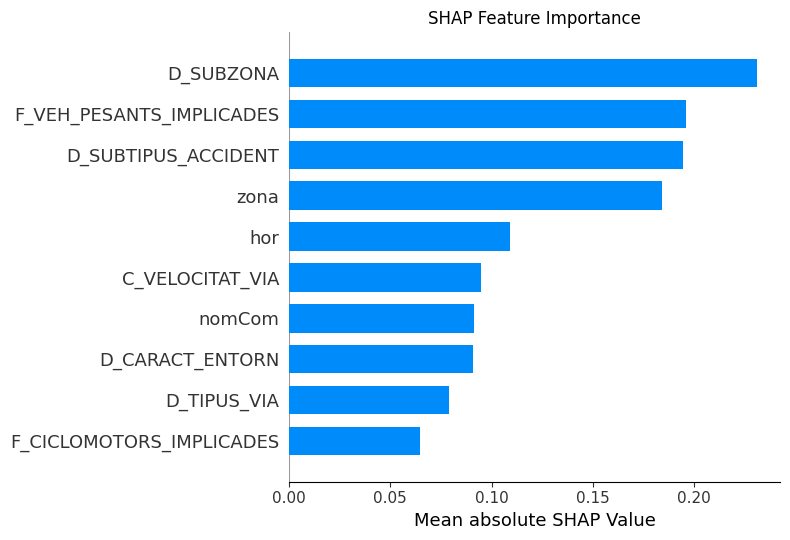

In [130]:
booster = final_model.get_booster()
explainer = shap.TreeExplainer(booster)
shap_values = explainer(X_test_scaled)

# Generate a SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_test_scaled, show=False, plot_type='bar', max_display=10)
plt.title(f'SHAP Feature Importance')
plt.xlabel('Mean absolute SHAP Value')
plt.tight_layout()
plt.show()

As mentioned earlier, the most important features are: the zone where the accident ocurred (urban/rural), the number of heavy vehicles involved, and the type of accident. The first four features show a strong impact. However, after the fourth feature, the impact is considerably smaller.

The following beeswarm provides more insights on how these features impact predictions.

- When F_VEH_PESANTS_IMPLICADES increases (i.e. more heavy vehicles involved), the prediction is pushed to 'mortality'.
- When VELOCITAT_VIA increases, accident mortality increases.

The rest of features (mostly categorical) are better interpreted with the plot above, as their numerical values are not meaningful in this plot.

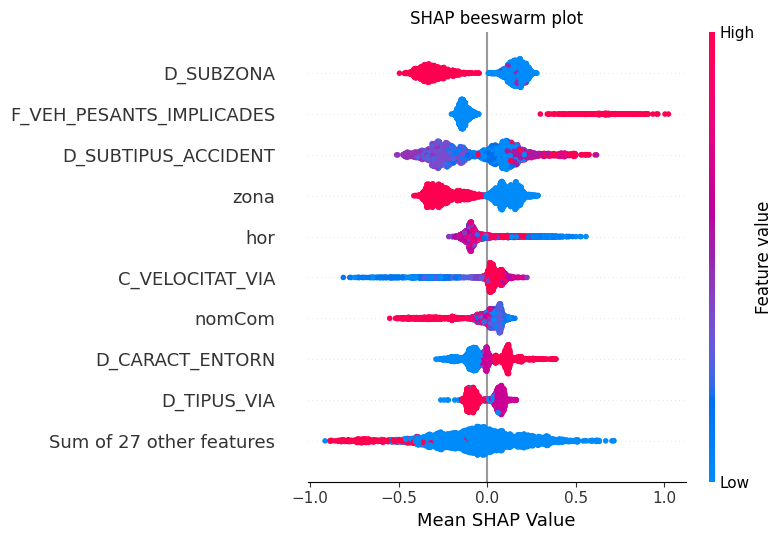

In [131]:
plt.figure(figsize=(8, 6))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title(f'SHAP beeswarm plot')
plt.xlabel('Mean SHAP Value')
plt.tight_layout()
plt.show()

### Local explainability

In this section we aim to see how features affect to a particular sample instead of the whole data. First, let us generate a waterfall plot of the first sample of the testing dataset.

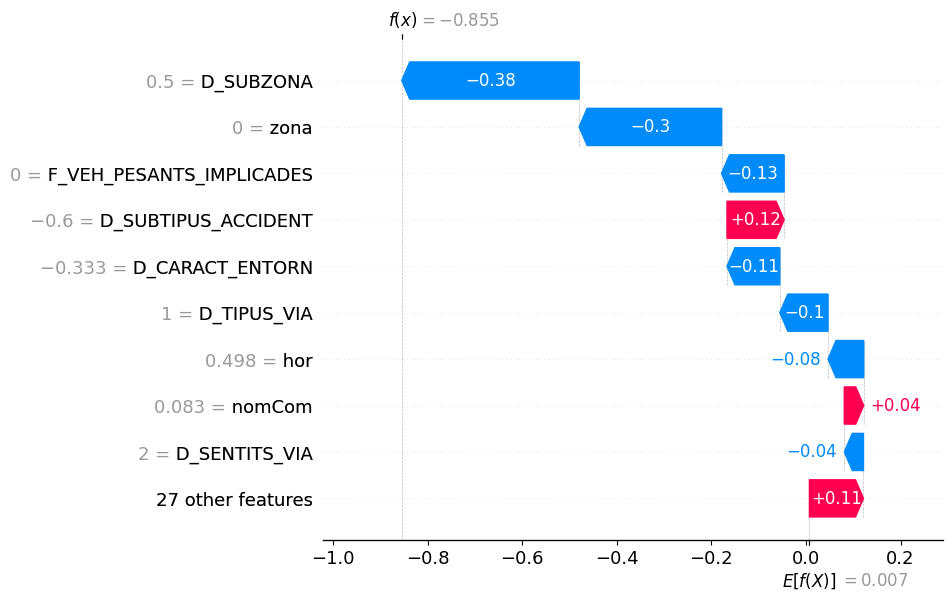

In [132]:
# Assuming 'model' is your trained model and 'X_test_scaled' is your scaled test dataset
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test_scaled)

# Create a waterfall plot for the first sample
shap.waterfall_plot(shap_values[0])

Now, let us generate a new sample and see how it is affected by the different features.

In [133]:
# Load the label encoders
with open('../output/label_encoders.pkl', 'rb') as f:
    le_dict = pickle.load(f)

In [134]:
sample = pd.Series({
    "Any": 2012,
    "zona": "Carretera",
    "nomCom": "Garrigues",
    "nomDem": "Lleida",
    "F_UNITATS_IMPLICADES": 2,
    "F_VIANANTS_IMPLICADES": 0,
    "F_BICICLETES_IMPLICADES": 0,
    "F_CICLOMOTORS_IMPLICADES": 0,
    "F_MOTOCICLETES_IMPLICADES": 0,
    "F_VEH_LLEUGERS_IMPLICADES": 1,
    "F_VEH_PESANTS_IMPLICADES": 1,
    "C_VELOCITAT_VIA": 100,
    "D_BOIRA": "No n'hi ha",
    "D_CARACT_ENTORN": "Mixt",
    "D_CARRIL_ESPECIAL": "Carril central",
    "D_CIRCULACIO_MESURES_ESP": "No n'hi ha",
    "D_CLIMATOLOGIA": "Bon temps",
    "D_FUNC_ESP_VIA": "Sense funció especial",
    "D_INTER_SECCIO": "En secció",
    "D_LIMIT_VELOCITAT": "Genérica via",
    "D_LLUMINOSITAT": "Alba o capvespre",
    "D_REGULACIO_PRIORITAT": "Semàfor",
    "D_SENTITS_VIA": "Doble sentit",
    "D_SUBTIPUS_ACCIDENT": "Fregament o col·lisió lateral",
    "D_SUBTIPUS_TRAM": "Giratòria",
    "D_SUBZONA": "Carretera",
    "D_SUPERFICIE": "Sec i net",
    "D_TIPUS_VIA": "Carretera convencional",
    "D_TITULARITAT_VIA": "Estatal",
    "D_TRACAT_ALTIMETRIC": "Pla",
    "D_VENT": "Calma, vent molt suau",
    "hor": 7.2,
    "grupHor": "Matí",
    "tipAcc": "Col.lisió de vehicles en marxa",
    "tipDia": "dis",
    "Mes": 7
})

c:\Users\User\Desktop\Uni\4to\visual analytics\final-project\catalan-traffic-accident-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(



Prediction: 1 (Mortality)
Probability of mortality: 71.22%


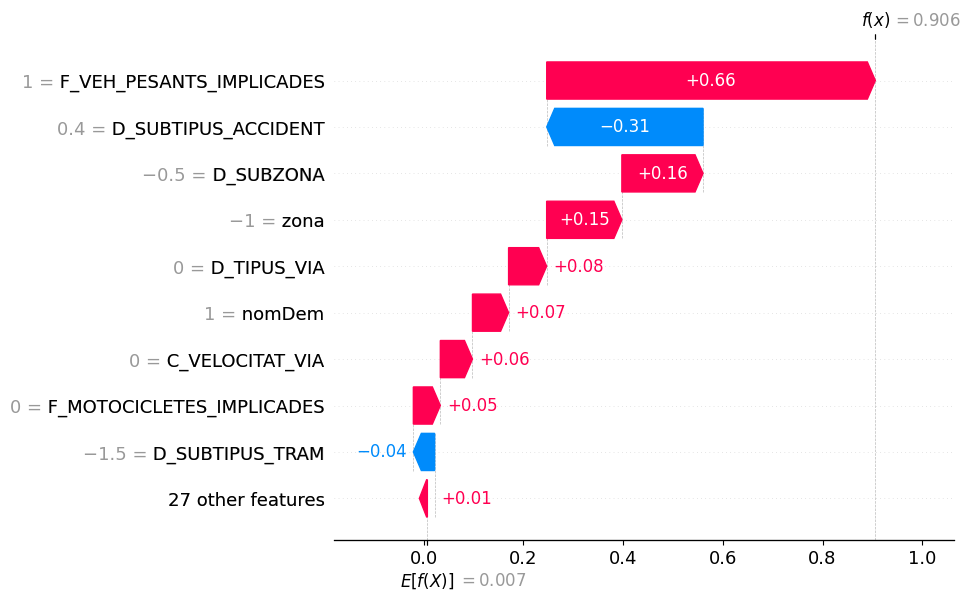

In [135]:
# Encode the sample
for col, encoder in le_dict.items():
    if col in sample.index:
        sample[col] = encoder.transform([sample[col]])[0]

# Scale the sample
sample_scaled = scaler.transform([sample])

# Convert back to DataFrame for SHAP
sample_scaled_df = pd.DataFrame(sample_scaled, columns=sample.index)

# Make prediction
prediction = final_model.predict(sample_scaled_df)
prediction_proba = final_model.predict_proba(sample_scaled_df)

print(f"\nPrediction: {prediction[0]} ({'Mortality' if prediction[0] == 1 else 'No Mortality'})")
print(f"Probability of mortality: {prediction_proba[0][1]:.2%}")

# Create SHAP values
explainer = shap.Explainer(final_model)
shap_values = explainer(sample_scaled_df)

# Create a waterfall plot for the chosen sample
shap.waterfall_plot(shap_values[0])

In this case, we observe how a single heavy vehicle being involved pushes the prediction to 'mortality'. The subzone (carretera) has a similar effect. Although the final prediction is 'mortality', the accident type (lateral colission) makes the model decrease its probability slightly, showing how these type of accidents favours negative predictions in the model.

## 5.3 Threshold justification

recall-precision tradeoff

for those predicted mortality that weren't mortal, are these accidents severe?

## Final testing